# Principal Component Analysis (PCA) on Employee_data

The goal of Principal Component Analysis (PCA) is to reduce the **number of dimensions** of a d-dimensional dataset by projecting it onto a k-dimensional subspace (with k < d) in order to increase the **computational efficiency** while retaining most of the information.

The k dimensions that we keep (eigenvectors) are called "**principal components**".

The PCA approach requires to:

* Standardize the data.
* Obtain the Eigenvectors and Eigenvalues from a Singular Vector Decomposition (SVD) of the data matrix.
* Choose the number k of principal components to keep.
* Construct a projection matrix with the selected k eigenvectors.
* Project original dataset to a k-dimensional feature subspace.

Choosing the number k can be done systematically by selecting the components that best describe the variance in our data. The amount of information (variance) contained by each eigenvector can be measured by the **explained variance**.

This notebook will display the explained variance for your dataset and help you choose the right amount of eigenvectors ("principal components").

* [Setup and loading the data](#setup)
* [Preprocessing of the data](#preprocessing)
* [Computation of the PCA](#pca)
* [Display of the explained variance](#explained-variance)
* [Retaining of the most significant components](#final-pca)
* [Visualizing the vectors in the original space](#original-space)

<center><strong>Select Cell > Run All to execute the whole analysis</strong></center>

## Setup and dataset loading <a id="setup" /> 

First of all, let's load the libraries that we'll use

In [1]:
import sys                          
import pandas as pd, numpy as np             # Data manipulation 
from sklearn.decomposition import PCA        # The main algorithm
from matplotlib import pyplot as plt         # Graphing
import seaborn as sns                        # Graphing
from collections import defaultdict, Counter # Utils
sns.set(style="white")                       # Tuning the style of charts
import warnings                              # Disable some warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

The first thing we do is now to load the dataset and put aside the three main types of columns:

* Numerical
* Categorical
* Date

Since analyzing PCA requires to have the data in memory, we are only going to load a sample of the data. Modify the following cell to change the size of the sample.

Also, by default, date features are not kept. Modify the following cell to change that.

In [2]:
dataset_limit = 10000
keep_dates = False

# load the data file 
!pip install openpyxl
df = pd.read_excel('DATA/Employee_data.xlsx', index_col=0)
df.head()

Defaulting to user installation because normal site-packages is not writeable


,gender,bdate,educ,jobcat,salary,salbegin,jobtime,prevexp,minority,age
id,,,,,,,,,,
0,m,1952-02-03 00:00:00,15,Manager,57000,27000,98,144,0,61.0
1,m,1958-05-23 00:00:00,16,Clerical,40200,18750,98,36,0,55.0
2,f,1929-07-26 00:00:00,12,Clerical,21450,12000,98,381,0,84.0
3,f,1947-04-15 00:00:00,8,Clerical,21900,13200,98,190,0,66.0
4,m,1955-02-09 00:00:00,15,Clerical,45000,21000,98,138,0,58.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 474 entries, 0 to 473
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    474 non-null    object 
 1   bdate     474 non-null    object 
 2   educ      474 non-null    int64  
 3   jobcat    474 non-null    object 
 4   salary    474 non-null    int64  
 5   salbegin  474 non-null    int64  
 6   jobtime   474 non-null    int64  
 7   prevexp   474 non-null    int64  
 8   minority  474 non-null    int64  
 9   age       473 non-null    float64
dtypes: float64(1), int64(6), object(3)
memory usage: 40.7+ KB


In [4]:
# make a copy of the original dataframe
df_orig = df.copy()    

# Get the column names
numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
categorical_columns = list(df.select_dtypes(include=[object]).columns)
date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)

# Print a quick summary of what we just loaded
print("Loaded dataset")
print("   Rows: %s" % df.shape[0])
print("   Columns: %s (%s num, %s cat, %s date)" % (df.shape[1], 
                                                    len(numerical_columns), len(categorical_columns),
                                                    len(date_columns)))

Loaded dataset
   Rows: 474
   Columns: 10 (7 num, 3 cat, 0 date)


## Preprocessing of the data <a id="preprocessing" />

Keep the dates as features if requested by the user

In [5]:
columns_to_drop = []
if keep_dates:
    df[date_columns] = df[date_columns].astype(int)*1e-9
else:
    columns_to_drop.extend(date_columns)

columns_to_drop

[]

Get rid of the columns that contain too many unique values

In [6]:
DROP_LIMIT_ABS = 200
CAT_DROP_LIMIT_RATIO = 0.5
for feature in categorical_columns:
    nu = df[feature].nunique()
    
    if nu > DROP_LIMIT_ABS or nu > CAT_DROP_LIMIT_RATIO*df.shape[0]:
        print("Dropping feature %s with %s values" % (feature, nu))
        columns_to_drop.append(feature)

columns_to_drop

Dropping feature bdate with 462 values


['bdate']

We then need to impute missing values (or drop the records)

In [7]:
impute = True # you can change this

if impute:
    # Use mean for numerical features
    for feature in numerical_columns:
        v = df[feature].mean()
        if np.isnan(v):
            v = 0
        print("Filling %s with %s" % (feature, v))
        df[feature] = df[feature].fillna(v)

    # Use mode for categorical features
    for feature in categorical_columns:
        v = df[feature].value_counts().index[0]
        df[feature] = df[feature].fillna(v)

else:        
    # drop records
    df.dropna(inplace=True)

Filling educ with 13.4915611814346
Filling salary with 34419.56751054852
Filling salbegin with 17016.086497890294
Filling jobtime with 81.1097046413502
Filling prevexp with 95.86075949367088
Filling minority with 0.21940928270042195
Filling age with 56.76955602536998


Drop the columns

In [8]:
print("Dropping the following columns: %s" % columns_to_drop)
df = df.drop(columns_to_drop, axis=1)

Dropping the following columns: ['bdate']


For all categorical features, we are going to "dummy-encode" them (one-hot encoding). <BR>We consider a categorical variable the ones with object data type from the original dataset. <BR> We also remove the first category so that we limit the number of dummy variables created


In [9]:
# For categorical variables with more than those many values, we only keep the most frequent ones
LIMIT_DUMMIES = 20

# Only keep the top 20 values
def select_dummy_values(train, features):
    dummy_values = {}
    for feature in features:
        values = [
            value
            for (value, _) in Counter(train[feature]).most_common(LIMIT_DUMMIES)
        ]
        dummy_values[feature] = values
    return dummy_values

DUMMY_VALUES = select_dummy_values(df, [x for x in categorical_columns if not x in columns_to_drop])

def dummy_encode_dataframe(df):
    for (feature, dummy_values) in DUMMY_VALUES.items():
        for dummy_value in dummy_values[1:]: # we start from the 2nd category
            if sys.version_info > (3,0):
                dummy_name = '%s_value_%s' % (feature, dummy_value)
            else:
                dummy_name = u'%s_value_%s' % (feature, dummy_value.decode('utf-8'))
            df[dummy_name] = (df[feature] == dummy_value).astype(float)
        del df[feature]
        print('Dummy-encoded feature %s' % feature)

dummy_encode_dataframe(df)

Dummy-encoded feature gender
Dummy-encoded feature jobcat


In [10]:
df.columns

Index(['educ', 'salary', 'salbegin', 'jobtime', 'prevexp', 'minority', 'age',
       'gender_value_f', 'jobcat_value_Manager', 'jobcat_value_Technical'],
      dtype='object')

We now need to check variables ARE correlated and standardize the ones to use for the analysis

<Axes: >

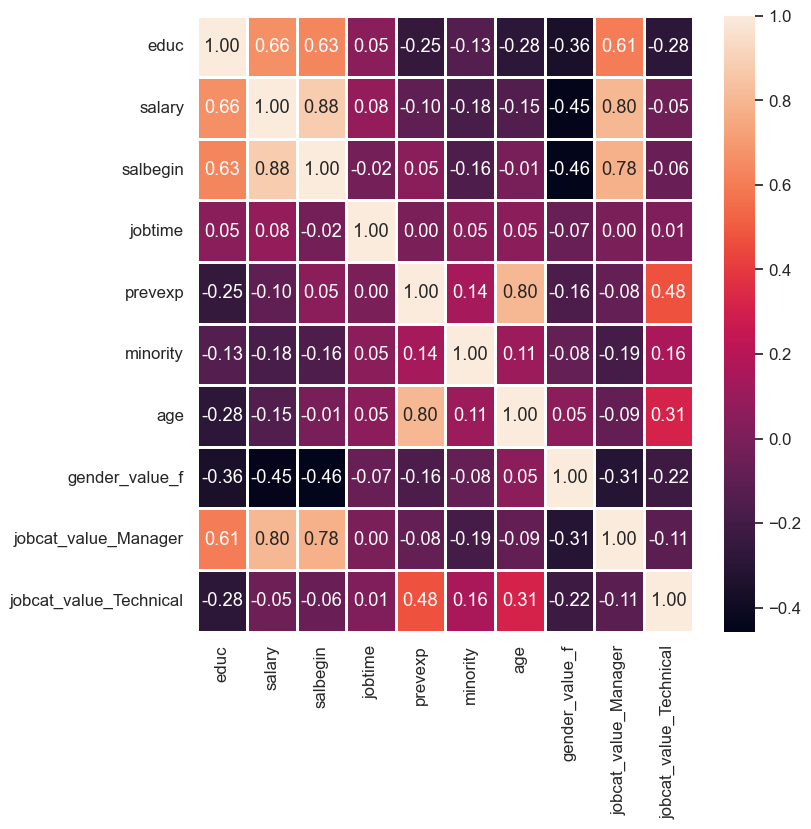

In [11]:
# Heatmap to show correlation between explanatory variables
sns.set(font_scale=1.1)
fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
sns.heatmap(df.corr(), annot=True, fmt=".2f", linewidths=1, ax=ax)

Finally, we rescale the whole data

In [12]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(df)
X_std = ss.transform(df)

## Computation of the PCA <a id="pca" />

Let's "fit" the PCA algorithm (in other words, let's compute the singular value decomposition)
<BR> Fit does the SVD and transform applies parameters to project data into new space

In [13]:
sklearn_pca = PCA()
Y_sklearn = sklearn_pca.fit_transform(X_std)

Here the PCA is a full SVD (k variables = d dimensions, we have not yet applied any "reduction").

## Display of the explained variance of the eigenvectors. <a id="explained-variance" />

The first thing to do after fitting a PCA algorihtm is to plot the **explained variance** of each eigenvector (how much information from the original data does each vector contain).

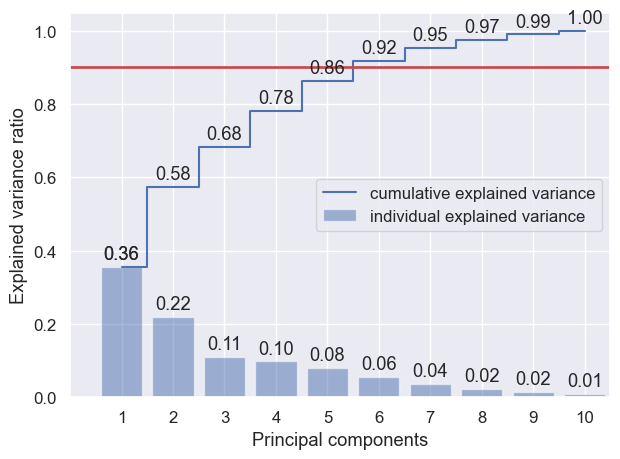

In [14]:
plt.bar(range(1,sklearn_pca.n_components_+1), sklearn_pca.explained_variance_ratio_, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(1,sklearn_pca.n_components_+1), [sklearn_pca.explained_variance_ratio_[:y].sum() for y in range(1,sklearn_pca.n_components_+1)], where='mid',label='cumulative explained variance')
plt.axhline(y=0.90, linewidth=2, color = 'r')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
for i, ratio in enumerate(sklearn_pca.explained_variance_ratio_):
    plt.text(i+1, ratio + 0.01, f'{ratio:.2f}', ha='center', va='bottom')
for i, ratio in enumerate([sklearn_pca.explained_variance_ratio_[:y].sum() for y in range(1,sklearn_pca.n_components_+1)]):
    plt.text(i+1, ratio + 0.01, f'{ratio:.2f}', ha='center', va='bottom')

plt.xlim([0, sklearn_pca.n_components_+0.5])
plt.xticks(range(1, sklearn_pca.n_components_ + 1))
plt.legend(loc='best')
plt.tight_layout()

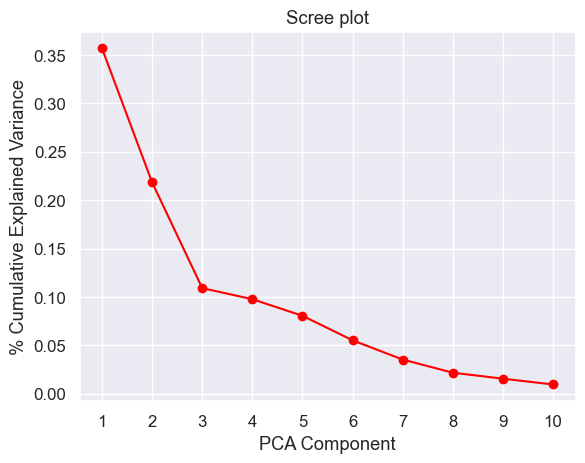

In [15]:
# Scree plot 
plt.plot(
    range(1,len(sklearn_pca.explained_variance_ratio_ )+1),
    sklearn_pca.explained_variance_ratio_,
    c='red', marker='o'
)
plt.xticks(range(1, len(sklearn_pca.explained_variance_ratio_) + 1))   
plt.xlabel('PCA Component')
plt.ylabel('% Cumulative Explained Variance')
plt.title('Scree plot')
plt.show()

## Retaining only some vectors <a id="final-pca" />

Now you should decide how many of these vectors (in order) must be used to retain a proportion of 
the variance of the original dataset accordingly <BR>(change that figure (0.65) below)

In [21]:
VARIANCE_TO_KEEP = 0.65 # that would mean two componentes in our example
keep_recommend = [sklearn_pca.explained_variance_ratio_[:y].sum()>VARIANCE_TO_KEEP for y in range(1,sklearn_pca.n_components_+1)].count(False)
print("Number of components to keep to retain %s%% of the variance:" % (100*VARIANCE_TO_KEEP), keep_recommend, "out of the original", sklearn_pca.n_components_)
n_components = keep_recommend

Number of components to keep to retain 65.0% of the variance: 2 out of the original 10


Let's run the PCA again but with the  number of components we have chosen this time

In [22]:
sklearn_pca_final = PCA(n_components)
Y_sklearn = sklearn_pca_final.fit_transform(X_std)

## Visualizing the eigenvectors in the original feature space <a id="original-space" />

### Decomposition heatmap

Each of our eigenvectors has a linear decomposition in the original feature space.

To understand which features were the most important, we can see how our eigenvectors are made of each original feature.

In [24]:
# Shows Factor loadings = correlations between variables and factors
print ("")
print ("Factor loadings:")

pd.set_option('display.float_format', '{:.4f}'.format)

dfloadings=pd.DataFrame(
    data    = sklearn_pca_final.components_,
    columns = df.columns,
)

index_list=[]
for n in range(n_components):
    index_list.append("PC"+str(n+1))

dfloadings.index = index_list

# Hide low values so that it is clearer
dfloadings.T.where(abs(dfloadings.T) > 0.3  , "")  # we hide values lower than 0.25 to better display the relations


Factor loadings:


,PC1,PC2
educ,0.4356,
salary,0.4883,
salbegin,0.4698,
jobtime,,
prevexp,,0.5993
minority,,
age,,0.5236
gender_value_f,,
jobcat_value_Manager,0.4555,
jobcat_value_Technical,,0.4464


## Assess the solution 

Do you see any variable that must be removed?
If so, we would have to start from scratch

If not, are we able to set up factor labels?

### Communalities
In order to calculate communalities (% of information explained from each variable), we need to square the Factor loadings of each variable.

In [25]:
# Communalities
commun=[]

for col in dfloadings.columns:
    commun.append((dfloadings.iloc[0:3][col]**2).sum())
    
dfcommun = pd.DataFrame(commun,index=dfloadings.columns, columns=["Communalities"])
dfcommun.sort_values("Communalities", ascending=False)

,Communalities
prevexp,0.3756
age,0.2990
salbegin,0.2568
salary,0.2520
jobcat_value_Manager,0.2162
jobcat_value_Technical,0.2128
educ,0.1954
gender_value_f,0.1485
minority,0.0405
jobtime,0.0032


### Component plot

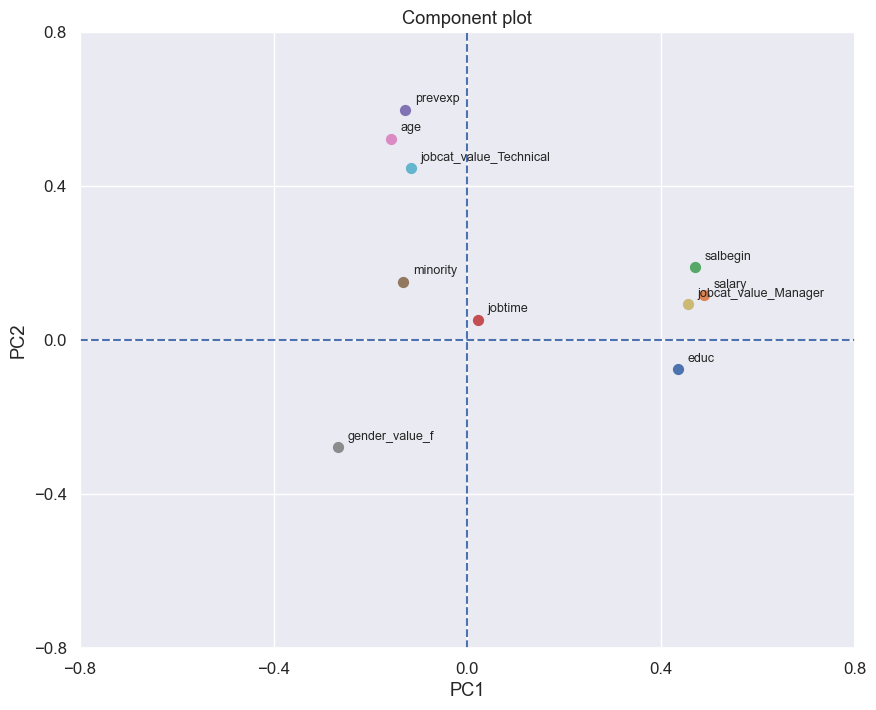

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Get the loadings of x and y axes
dfloadT = dfloadings.T

xs = dfloadT.PC1
ys = dfloadT.PC2
 
plt.figure(figsize=(10, 8))
plt.axvline(x=0, color='b', linestyle='dashed')
plt.axhline(y=0, color='b', linestyle='dashed')

# Plot the loadings on a scatterplot
for i, varnames in enumerate(dfloadings.columns):
    plt.scatter(xs.iloc[i], ys.iloc[i], s=50)
    
    # Slightly offset the text to avoid overlap
    plt.text(xs.iloc[i] + 0.02, ys.iloc[i] + 0.02, varnames, fontsize=9)

# Define the axes and show plot
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Component plot')

# Save the plot and show it
plt.savefig('Component_plot.png', bbox_inches='tight')  # Avoid cutting parts off
plt.show()

### Visualizing relation between 2 projected vectors

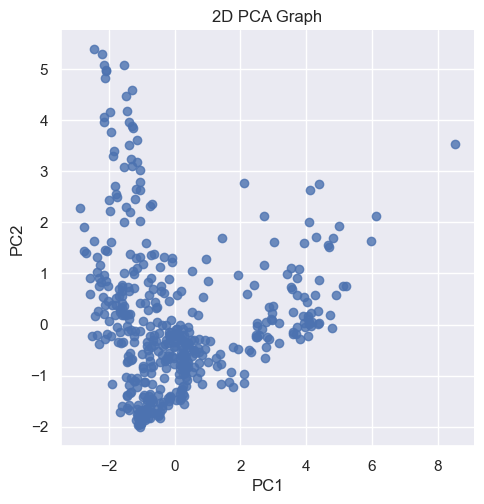

In [27]:
# Create dataframe of two components to display them

sklearn_pca_2 = PCA(n_components=2)
Y_sklearn_2 = sklearn_pca_2.fit_transform(X_std)
indx=np.arange(1, Y_sklearn_2.shape[0]+1)

pca_df_2 = pd.DataFrame(
    data=Y_sklearn_2, 
    columns=['PC1', 'PC2'])

sns.set()
sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df_2, 
    fit_reg=False, 
    legend=True
    )
 
plt.title('2D PCA Graph')
plt.show()

In [28]:
# Data Projections can also be shown
pca_df_2

,PC1,PC2
0,2.7149,1.1747
1,0.9124,-0.2972
2,-1.9792,2.2257
3,-2.0237,0.4662
4,0.8676,0.5346
...,...,...
469,-0.6360,-0.2038
470,-0.0927,-0.6269
471,0.5722,-0.8314
472,-1.6043,0.3177


And we combine original data with components created and export all to Excel

In [29]:
frames = [df_orig, pca_df_2]
df_norot = pd.concat(frames,axis=1)
df_norot.to_excel("DATA/Final_norotations.xlsx")

## Rotations
We apply one rotation method. Rotations  are applied to find a clearer structure of the underlying factors in the data.
<BR> Varimax mximizes the variances of the factor loadings to try  each variable has a high loading on a single factor.


In [30]:
!pip install factor_analyzer
from factor_analyzer import Rotator

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42623 sha256=8fd415394737f63a16051a51234df58361d4e39eff6bc106649b3e0502781c7c
  Stored in directory: c:\users\slo\appdata\local\pip\cache\wheels\dc\e7\b2\fe6cdba32701f1f5100b62d568213e95b2a52c4517e165db5e
Successfully built factor_analyzer


In [31]:
rotator = Rotator(method='varimax')
rotated_loadings = rotator.fit_transform(dfloadings.T)

df_varimax = pd.DataFrame(rotated_loadings, columns = ['PC1','PC2'], index=df.columns)
print("")
print("Varimax rotation: ")
df_varimax.where(abs(df_varimax) > 0.25  , "")


Varimax rotation: 


,PC1,PC2
educ,0.3978,
salary,0.5015,
salbegin,0.5040,
jobtime,,
prevexp,,0.6114
minority,,
age,,0.5468
gender_value_f,-0.3329,
jobcat_value_Manager,0.4636,
jobcat_value_Technical,,0.4611


In [ ]:
# Represent the component plot rotated
xs = df_varimax.PC1
ys = df_varimax.PC2
 
plt.figure(figsize = (10, 8))
plt.axvline(x = 0, color = 'b', linestyle = 'dashed')
plt.axhline(y = 0, color = 'b', linestyle = 'dashed')

# Plot the loadings on a scatterplot
for i, varnames in enumerate(df_varimax.T):
    plt.scatter(xs.iloc[i], ys.iloc[i], s=50)
    plt.text(xs.iloc[i] + 0.02, ys.iloc[i] + 0.02, varnames, fontsize=9)
 
# Define the axes
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')
 
# Show plot
plt.title('Component plot varimax rotation')
plt.savefig('Component plot varimax rotation.png')
plt.show()